In [33]:
import gc
import itertools
import sys
import cv2
import argparse
import datetime
import io
import numpy as np
import os
import pandas as pd
import pathlib
import random
import seaborn as sns
import shutil
import tensorflow as tf
import tensorflow_similarity as tfsim
import tensorflow_addons as tfa
from collections import Counter
from inspect import signature
from keras import activations, losses, models, optimizers
from keras.callbacks import (
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from matplotlib import pyplot as plt
from pathlib import Path
from scipy import stats
from sklearn import metrics  # For loss functions
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    accuracy_score,
    auc,
    average_precision_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow_similarity.types import Lookup, Tensor
from typing import Mapping, Optional, Sequence, Tuple
from tensorboard.plugins import projector

mitbih_dict = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
ptbdb_dict = {'Normal': 0, 'Abnormal': 1}


In [31]:
def get_data(data, data_path, zscore=True):
    if data == "mitbih":
        df_train = pd.read_csv(data_path+"/mitbih_train.csv", header=None)
        df_train = df_train.sample(frac=1)
        df_test = pd.read_csv(data_path+"/mitbih_test.csv", header=None)

        Y = np.array(df_train[187].values).astype(np.int8)
        X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

        Y_test = np.array(df_test[187].values).astype(np.int8)
        X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    elif data == "ptbdb":
        df_1 = pd.read_csv(data_path+"/ptbdb_normal.csv", header=None)
        df_2 = pd.read_csv(data_path+"/ptbdb_abnormal.csv", header=None)
        df = pd.concat([df_1, df_2])

        df_train, df_test = train_test_split(
            df, test_size=0.2, random_state=1337, stratify=df[187])

        Y = np.array(df_train[187].values).astype(np.int8)
        X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

        Y_test = np.array(df_test[187].values).astype(np.int8)
        X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    if zscore:
        X = stats.zscore(X, axis=1)
        X_test = stats.zscore(X_test, axis=1)

    return X, X_test, Y, Y_test
def get_model(data, model_name):
    time_steps = 187
    features = 1
    if data == "mitbih":
        number_class = 5
        activation_function = "softmax"
        loss = losses.sparse_categorical_crossentropy
    elif data == "ptbdb":
        number_class = 1
        activation_function = "sigmoid"
        loss = losses.binary_crossentropy
    if model_name == "ResNet":
        np.expand_dims(X_train, -1)
        np.expand_dims(Y_train, -1)
        model = ResNet(number_class, time_steps, features, activation_function)
    elif model_name == "CNN":
        model = CNN(number_class, time_steps, features, activation_function)
    elif model_name == "CNNDML":
        model = CNNDML(number_class, time_steps, features, activation_function)
    elif model_name == "RNN":
        model = RNN(number_class, time_steps, features, activation_function)
    elif model_name == "RNNDML":
        model = RNNDML(number_class, time_steps, features, activation_function)
    elif model_name == "BaseLine":
        model = BaseLine(number_class, time_steps,
                         features, activation_function)

    elif model_name == "Transformer":
        model = Transformer(number_class, time_steps,
                            features, activation_function)
    elif model_name == "LSTM_FCN":
        model = LSTM_FCN(number_class, time_steps,
                         features, activation_function)
    elif model_name == "Encoder":
        model = Encoder(number_class, time_steps,
                        features, activation_function)
    elif model_name == "EncoderDML":
        model = EncoderDML(number_class, time_steps,
                           features, activation_function)
    elif model_name == "RNNAdvanced":
        model = RNNAdvanced(number_class, time_steps,
                            features, activation_function)
    elif model_name == "CNN2":
        model = CNN2(number_class, time_steps, features, activation_function)
    return model, loss

def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    test_pred = model.predict(X_test)
    test_pred = np.argmax(test_pred, axis=-1)
    classes = [*mitbih_dict]
    cm = metrics.confusion_matrix(Y_test, test_pred)
    normalize = True
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    figure = plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(model_name+" Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the confusion matrix as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)


def plot_confusion_matrix(
    y_true,
    y_pred,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)
    plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


def plot_model_results(model, history, model_path, data, model_name, X_test, Y_test):
    model.load_weights(model_path)
    if model_name == "ResNet":
        X_test = np.expand_dims(X_test, -1)
        Y_test = np.expand_dims(Y_test, -1)
        model.evaluate(X_test, Y_test)
    if data == "mitbih":
        mitbih_dict = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
        pred_test = model.predict(X_test)
        pred_test = np.argmax(pred_test, axis=-1)

        pd.DataFrame(history.history).plot(figsize=(8, 5))

        f1 = f1_score(Y_test, pred_test, average="macro")
        acc = accuracy_score(Y_test, pred_test)

        print("Test F1 score : {:.4f}".format(np.mean(f1)))
        print("Test ACC score : {:.4f}".format(np.mean(acc)))

        plot_confusion_matrix(
            Y_test,
            pred_test,
            [*mitbih_dict],
            normalize=True,
            title="Confusion matrix",
            cmap=plt.cm.Blues)
    elif data == "ptbdb":
        ptbdb_dict = {'Normal': 0, 'Abnormal': 1}
        pred_test = model.predict(X_test)
        pred_test = (pred_test > 0.5).astype(np.int8)
        f1 = f1_score(Y_test, pred_test, average="macro")
        acc = accuracy_score(Y_test, pred_test)
        print("Test F1 score : {:.4f}".format(np.mean(f1)))
        print("Test ACC score : {:.4f}".format(np.mean(acc)))
        plot_confusion_matrix(
            Y_test,
            pred_test,
            [*ptbdb_dict],
            normalize=False,
            title="Confusion matrix",
            cmap=plt.cm.Blues)
        plot_roc(Y_test, pred_test)
        plot_precisionrecall(Y_test, pred_test)

## Paths and what data

In [24]:
working_path = pathlib.Path().resolve()
path_object = Path(working_path)
parent_path = path_object.parent
model_path_parent = os.path.join(parent_path, "03-Models")
data_path = os.path.join(parent_path, "01-Data")
tensorboard_path_parent = os.path.join(
    parent_path, "04-Logs/02-Mitbih/03-Task3")
projector_path = os.path.join(parent_path, "04-Logs")

In [25]:
#Load the mitbih or ptbdb data
data = "mitbih"
what_dict = mitbih_dict
X_train,X_test,Y_train,Y_test= get_data(data,data_path)


## Loading CNN, Prediction, Metrics and Confusion Matrix:


Test f1 score : 0.9275196307640765 
Test accuracy score : 0.9869815457701443 
Confusion matrix, without normalization
[[18051    33    20     9     5]
 [   96   447     8     3     2]
 [   43     3  1384    14     4]
 [   17     0    12   133     0]
 [   15     0     1     0  1592]]


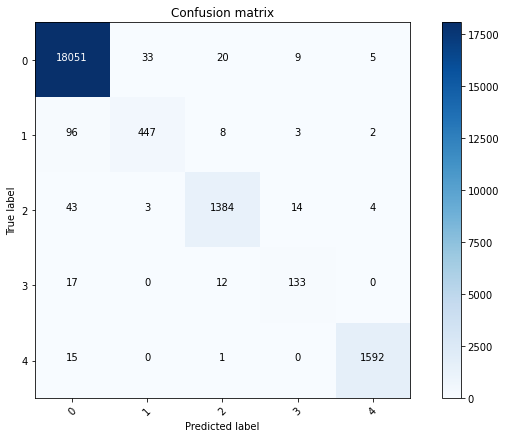

In [37]:
model_path = model_path = os.path.join(model_path_parent,"02-Mitbih/01-Task1/CNN_mitbih")
model = tf.keras.models.load_model(model_path)
pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

f1 = f1_score(Y_test, pred_test, average="macro")

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)
classes  = [*what_dict.values()] #class names
print("Test accuracy score : %s "% acc)
plot_confusion_matrix(
    Y_test,
    pred_test,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues)


## Load DMLCNN, Prediction, Metrics and Confusion Matrix

Distance metric automatically set to cosine use the distance arg to override.
Loading index data
loaded 78798 records from C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\01-ECG_Classification\03-Models\02-Mitbih\03-Task3\DMLCNN_mitbih\index
Loading search index
Loading calibration data
[Info]
------------------  ------
distance            cosine
key value store     memory
search algorithm    nmslib
evaluator           memory
index size          78798
calibrated          True
calibration_metric  f1
embedding_output
------------------  ------



[Performance]
-----------  -
num lookups  0
min          0
max          0
avg          0
median       0
stddev       0
-----------  -


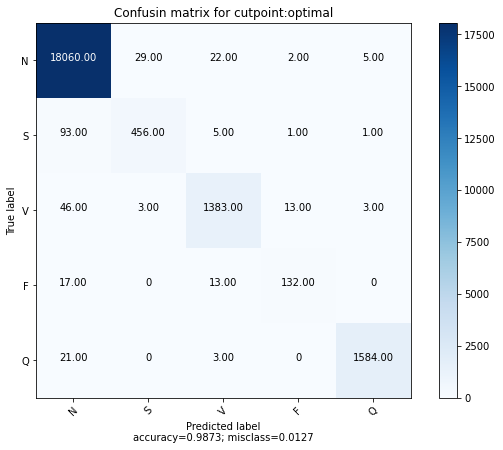

Test F1 score : 0.9342
Test ACC score : 0.9873


In [38]:
model_path = os.path.join(model_path_parent,"02-Mitbih/03-Task3/DMLCNN_mitbih")
reloaded_model = tf.keras.models.load_model(
model_path.replace(os.sep, '/'),
custom_objects={"SimilarityModel": tfsim.models.SimilarityModel},
)
reloaded_model.load_index(model_path)
reloaded_model.index_summary()
cutpoint = "optimal"
matches = reloaded_model.match(X_test, cutpoint=cutpoint, no_match_label=0)
labels = [*what_dict.keys()]

cm = tfsim.visualization.confusion_matrix(
    matches,
    Y_test,
    labels=labels,
    normalize=False,
    title="Confusin matrix for cutpoint:%s" % cutpoint,
)
f1 = f1_score(Y_test, matches, average="macro")
acc = accuracy_score(Y_test, matches)

print("Test F1 score : {:.4f}".format(np.mean(f1)))
print("Test ACC score : {:.4f}".format(np.mean(acc)))

## Create TB projections to load in online tensorboard projector https://projector.tensorflow.org/

In [9]:
model_path = os.path.join(model_path_parent,"02-Mitbih/03-Task3/DMLCNN_mitbih")
reloaded_model = tf.keras.models.load_model(
model_path.replace(os.sep, '/'),
custom_objects={"SimilarityModel": tfsim.models.SimilarityModel},
)


Distance metric automatically set to cosine use the distance arg to override.


In [18]:
emb = reloaded_model.predict(X_test)
class_mappings = {v: k for k, v in what_dict.items()}
meta = [class_mappings[y] for y in Y_test]

In [20]:
np.savetxt(projector_path+"/vectors_"+data+".tsv",emb,delimiter='\t')
with open(projector_path+"/metadata_"+data+".tsv", 'w') as f:
    for item in meta:
        f.write("%s\n" % item)

### now go to folder and load both files to the online projector

In [23]:
# for a direct visual in jupyter use:
%tensorboard --logdir {tensorboard_path_parent.replace(os.sep, '/')}


In [ ]:
# and for console mode (recommended), put in this with your adjusted path into your conda console with tensorboard installed
tensorboard --logdir='...\01-ECG_Classification\Submission\04-Logs\02-Mitbih\02-Task2' --bind_all